Epoch 1/60
2/2 [==============================] - 3s 536ms/step - loss: 800850.0625 - r_squared: -1.2962 - val_loss: 1355966.5000 - val_r_squared: -4.1236
Epoch 2/60
2/2 [==============================] - 0s 163ms/step - loss: 477793.8750 - r_squared: -0.1498 - val_loss: 841825.8125 - val_r_squared: -2.1809
Epoch 3/60
2/2 [==============================] - 0s 168ms/step - loss: 255253.0000 - r_squared: 0.3319 - val_loss: 386518.5312 - val_r_squared: -0.4605
Epoch 4/60
2/2 [==============================] - 0s 132ms/step - loss: 121601.5000 - r_squared: 0.6349 - val_loss: 275421.8125 - val_r_squared: -0.0407
Epoch 5/60
2/2 [==============================] - 0s 130ms/step - loss: 92019.3906 - r_squared: 0.8055 - val_loss: 196102.0625 - val_r_squared: 0.2590
Epoch 6/60
2/2 [==============================] - 0s 136ms/step - loss: 64075.3789 - r_squared: 0.8333 - val_loss: 179450.2812 - val_r_squared: 0.3220
Epoch 7/60
2/2 [==============================] - 0s 193ms/step - loss: 52488.4609 

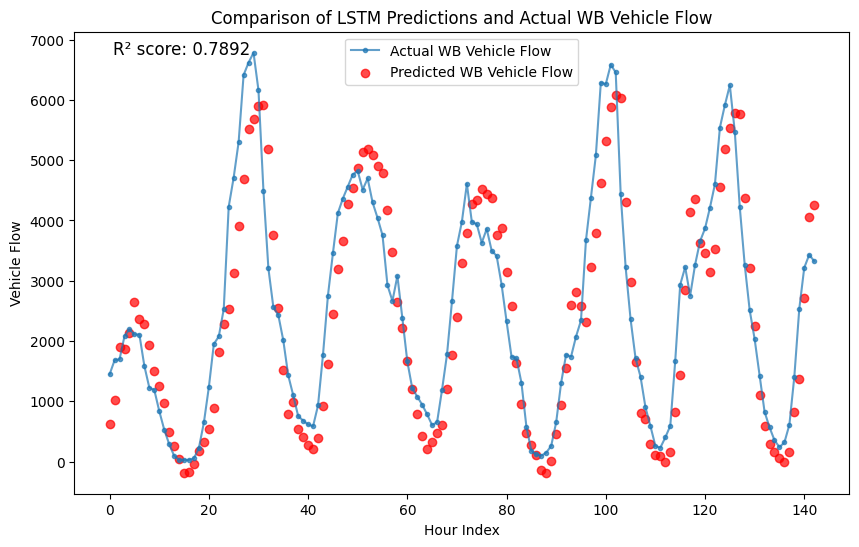

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Data loading and preprocessing
file_path = 'REV4-data_2.xlsx'  # Adjust to the actual uploaded file path
df = pd.read_excel(file_path)
pivot_df = df.pivot(index='datetime', columns='direction', values='total_vol')  # Ensure column names match the data
pivot_df_filled = pivot_df.fillna(method='ffill').fillna(method='bfill')

# Define the R^2 evaluation metric
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

# Sequence creation function, using N_HOURS as the time window
N_HOURS = 6  # Number of hours for forecasting, can be adjusted as needed
def create_sequences(input_data, target_column, N):
    X, y = [], []
    for i in range(len(input_data) - N):
        X.append(input_data.iloc[i:(i + N)].values)
        y.append(input_data.iloc[i + N][target_column])
    return np.array(X), np.array(y)

# Prepare complete sequence data
target_column = 'WB'  # Assuming we are focusing on the West Bound direction
X, y = create_sequences(pivot_df_filled, target_column, N_HOURS)

# Define and build the LSTM model function
def build_lstm_model(input_shape, dropout_rate=0.2, l2_lambda=0.01):
    model = Sequential([
        LSTM(550, activation='relu', input_shape=input_shape,
             kernel_regularizer=l2(l2_lambda),  # Apply L2 regularization
             recurrent_regularizer=l2(l2_lambda)),  # Apply regularization to the recurrent kernel as well
        Dropout(dropout_rate),  # Add a Dropout layer
        Dense(1, kernel_regularizer=l2(l2_lambda))  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[r_squared])
    return model

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
best_model = None
best_score = -np.inf
best_X_test = None
best_y_test = None
all_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Rebuild the model every time
    model = build_lstm_model(input_shape=(N_HOURS, X_train.shape[2]))

    # Set up early stopping strategy
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, epochs=60, batch_size=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # Model evaluation
    _, r2_score = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(r2_score)
    if r2_score > best_score:
        best_score = r2_score
        best_model = model
        best_X_test = X_test
        best_y_test = y_test

    print(f"R² score for split {len(all_scores)}: {r2_score}")

# Print scores for all splits
print("All R² scores:", all_scores)

# Use the best model for prediction and visualization
predictions = best_model.predict(best_X_test)

plt.figure(figsize=(10, 6))
plt.plot(best_y_test, label='Actual WB Vehicle Flow', marker='.', linestyle='-', alpha=0.7)
plt.scatter(range(len(predictions)), predictions.flatten(), label='Predicted WB Vehicle Flow', marker='o', linestyle='None', alpha=0.7, color='red')
plt.title('Comparison of LSTM Predictions and Actual WB Vehicle Flow')
plt.xlabel('Hour Index')
plt.ylabel('Vehicle Flow')
plt.legend()

# Assume 'best_r2_score' is the previously stored best R² value
# Add an annotation of the R² value directly on the chart
plt.text(0.05, 0.95, f'R² score: {best_score:.4f}', transform=plt.gca().transAxes, fontsize=12)

plt.show()
